In [51]:
import sys
if not '..' in sys.path:
    sys.path.append('..')

from pathlib import Path
from analysis import files, collection, emg
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib inline

## For each target: 
- compute average correlation between (normalized) task-space decoder axes and target vector
- now you have 12 correlations for each subject
- for each target, across subjects, how well does that decoder correlation predict performance per target?
- plot = subjects' total performance (hits) per target vs. decoder corr for that target -- plot all targets together? (color-coded?)

### how are the offsets and variance calculated?

offsets -- extract quiescent periods before movement cue is given, filter these and take the mean. this is then subtracted from the "live" signal as a shift.

variance -- this is computed per channel from the calibration bars dataset, divided per channel as a whitening

## get decoders

In [52]:
c = collection.Collection("emg_olympics")
# first alphabetical subject in the dict
s = c.subjects[c.subject_names[0]]

Text(0.5, 0, 'Radial Decoder Channel ($y$)')

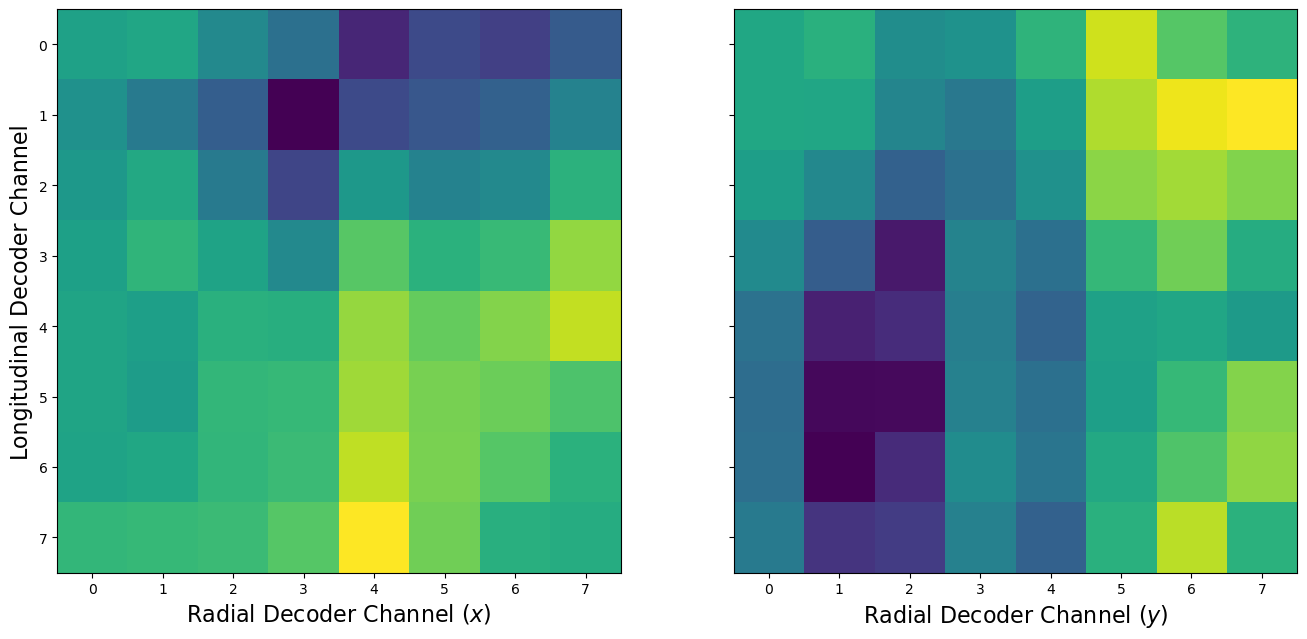

In [53]:
decoder = s.decoder
decoder_heatmap_fig, axes = plt.subplots(1,2,figsize=[16,8],sharex=True, sharey=True)
axes[0].imshow(decoder[-2,:].reshape(8,8))
axes[0].set_xlabel("Radial Decoder Channel ($x$)", fontsize=16)
axes[0].set_ylabel("Longitudinal Decoder Channel", fontsize=16)
axes[1].imshow(decoder[-1,:].reshape(8,8))
axes[1].set_xlabel("Radial Decoder Channel ($y$)", fontsize=16)

## plot decoder directions in task space

In [ ]:
def avg_cosine_with_target(target, decoder):
    # get target vectors
    # get decoder vectors
    # 1 - (dot(x,y) / norm(x)*norm(y))

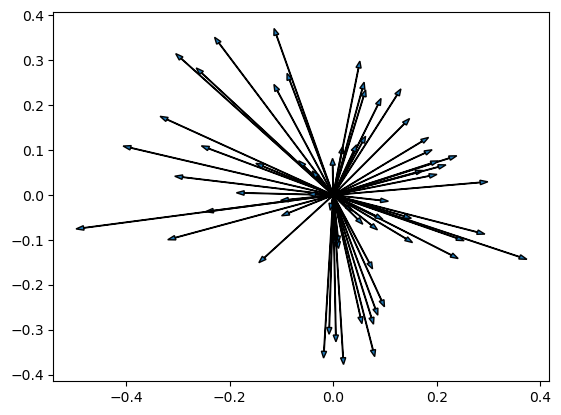

In [54]:
# plot x and y components of the decoder
# this visualizes correlations in task space
for col in decoder[-2:,:].T:
    plt.arrow(0,0,col[0],col[1],head_width=.01)

In [55]:
# decoder_heatmap_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/decoder_heatmap.pdf", dpi=300, format="pdf")

## hit percentages per target

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

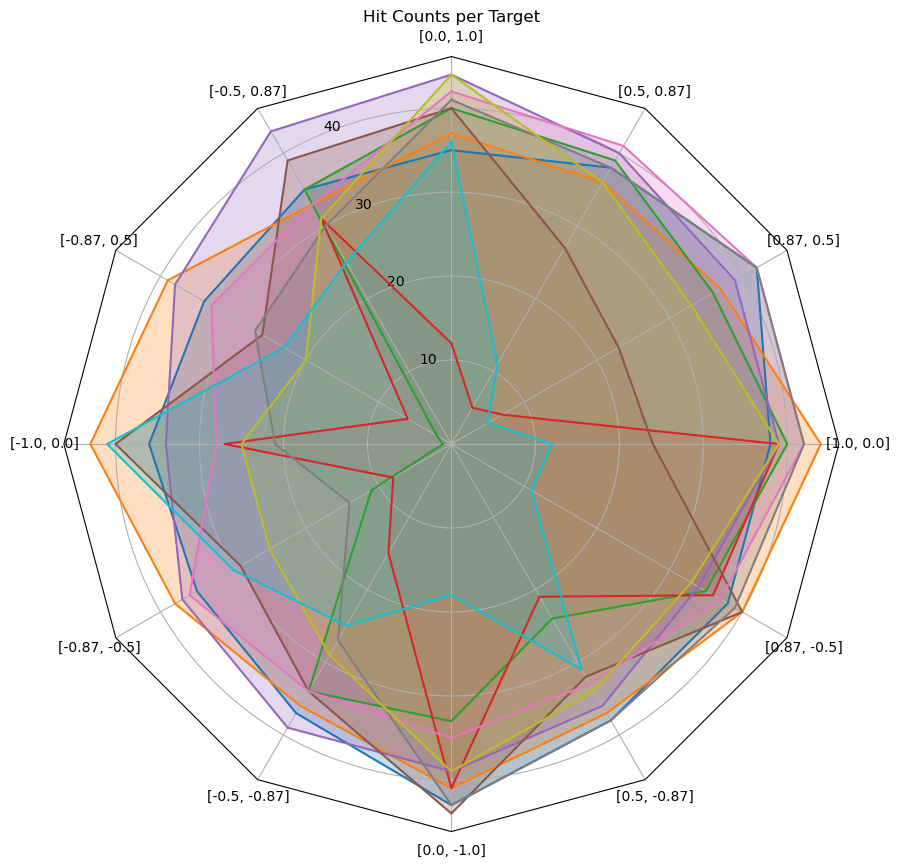

In [ ]:
data = []
for subject in c.alphabetically_sorted_subjects():
    sessions  = subject.tasks["center_hold"].sorted_sessions()
    hit_counts_per_target = {}
    for sesh in sessions:
        trials = sesh.sorted_trials()
        for trial in trials:
            # get outcome
            oc = trial.outcome
            if oc == "Hit":
                # get target location
                try:
                    current_count = hit_counts_per_target[str(trial.target_coords)][1]
                    hit_counts_per_target[str(trial.target_coords)] = (trial.target_coords, current_count+1)
                except KeyError:
                    hit_counts_per_target[str(trial.target_coords)] = (trial.target_coords, 0)
    target_names = []
    counts = []
    # sort by theta angle
    for name, (coord, count) in sorted(hit_counts_per_target.items(), key=lambda s: np.arctan2(s[1][0][1],s[1][0][0])):
        target_names.append(name)
        counts.append(count)
    data.append(counts)


N = len(target_names)
theta = radar_factory(N, frame='polygon')

# roll these around to line up with plot coordinates
rollby=-8
spoke_labels = np.roll(np.array(target_names), rollby)
title = "Hit Counts per Target"

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.85, bottom=0.05)

ax.set_rgrids([10, 20, 30, 40, 50, 60])
ax.set_title(title,  position=(0.5, 1.1), ha='center')

for d in data[-10:]:
    d = np.roll(np.array(d), rollby)
    line = ax.plot(theta, d)
    ax.fill(theta, d,  alpha=0.25)
ax.set_varlabels(spoke_labels)

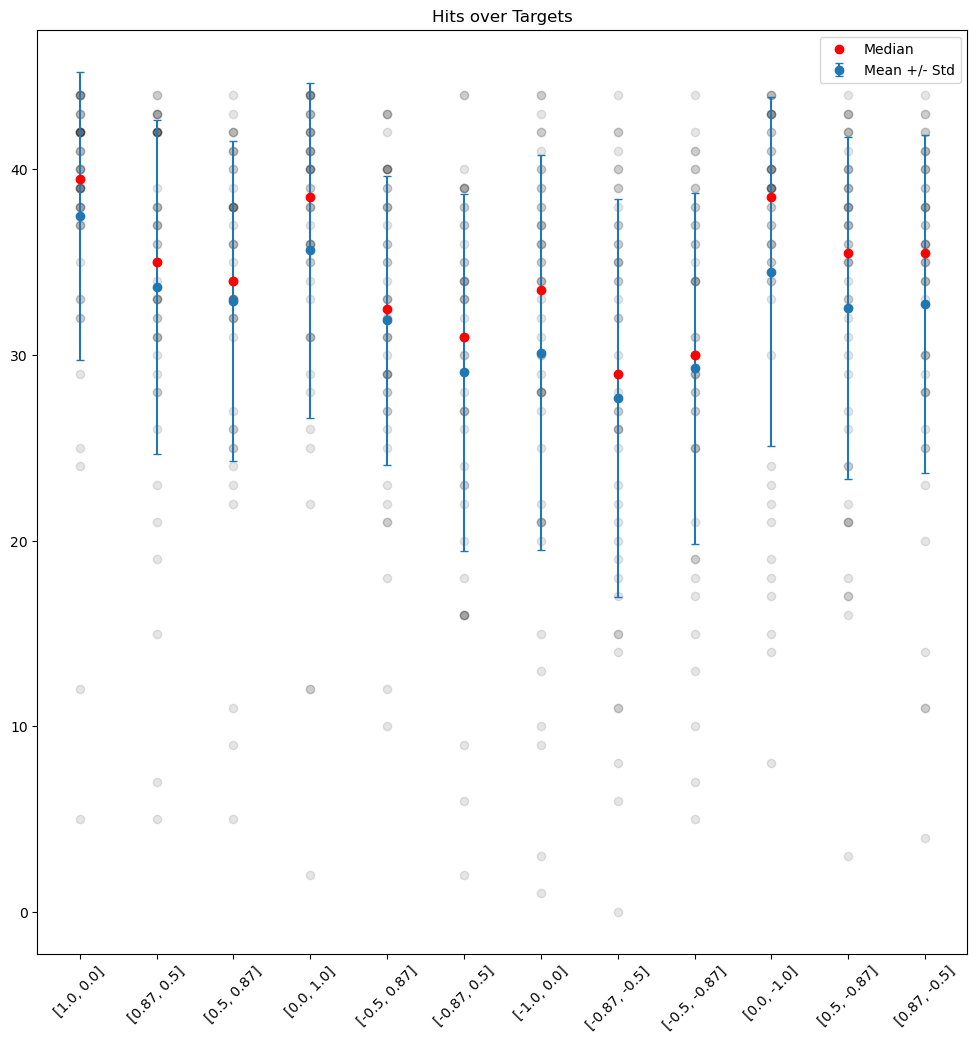

In [ ]:
rollby = 7
fig, ax = plt.subplots(1,1,figsize=(12,12))
for d in data:
    ax.plot(np.roll(d, rollby), 'ko', alpha=0.1)
ax.set_xticks(range(len(target_names)))
ax.set_xticklabels(np.roll(target_names, rollby), rotation=45)

means = np.mean(data,axis=0)
medians = np.median(data,axis=0)
stds = np.std(data,axis=0)
ax.errorbar(np.roll(target_names, rollby), np.roll(means, rollby), np.roll(stds, rollby), linestyle='None', marker='o', capsize=3, label="Mean +/- Std")
ax.plot(np.roll(target_names, rollby), np.roll(medians, rollby), 'ro', label="Median")
ax.set_title("Hits over Targets")
ax.legend()

In [ ]:
fig.savefig(image_path / "analysis/hits_over_targets.pdf", dpi=300, format="pdf")

## decode filtered EMG

In [ ]:
class Linear_Control():
    ## DYNAMICS ##
    # px, py, vx, vx, f_left, f_right, fy/f_up
    #
    # | e  0  t  0  0  0  0 | | px |
    # | 0  e  0  t  0  0  0 | | py |
    # | 0  0  e  0 -t  t  0 | | vx |
    # | 0  0  0  e  0  0  t | | vy |
    # | 0  0  0  0  e  0  0 | | fl |
    # | 0  0  0  0  0  e  0 | | fr |
    # | 0  0  0  0  0  0  e | | fy |
    #

    def __init__(self, state_dim=7):
        self.state_dim = state_dim
        self.cursor_state = np.zeros(shape=(self.state_dim, 1))
        # dynamics -- position, velocity, force all decay
        self.decay = 50  # very slow ~ 0.95
        self.dt = 0.1  # game time 100ms steps
        self.A = np.eye(self.state_dim) * np.exp(-1/self.decay)
        # velocities add to positions
        self.A[0, 2] = self.dt
        self.A[1, 3] = self.dt
        # forces add to velocity
        self.A[2, 4] = -self.dt
        self.A[2, 5] = self.dt
        self.A[3, 6] = self.dt

        # control mapping
        self.B = np.zeros((self.state_dim, NUM_ELECTRODES))
        # input acts only on the force rows
        self.B[-3, -3] = 1  # replace with mapping!
        self.B[-2, -2] = 1
        self.B[-1, -1] = 1

        # observation -- only feed back position
        self.observation = np.zeros((2, 1))
        self.H = np.zeros((2, self.state_dim))
        self.H[0, 0] = 1  # px
        self.H[1, 1] = 1  # py

    def advance_dynamics(self, control, scaling=1):
        control *= scaling
        self.cursor_state = self.A.dot(self.cursor_state) + self.B.dot(control)

    def advance_observation(self):
        self.observation = self.H.dot(self.cursor_state)

## plot outcomes vs. decoder correlation

0.05304496691303853


Text(0.5, 30, '$R^2$ = 0.053')

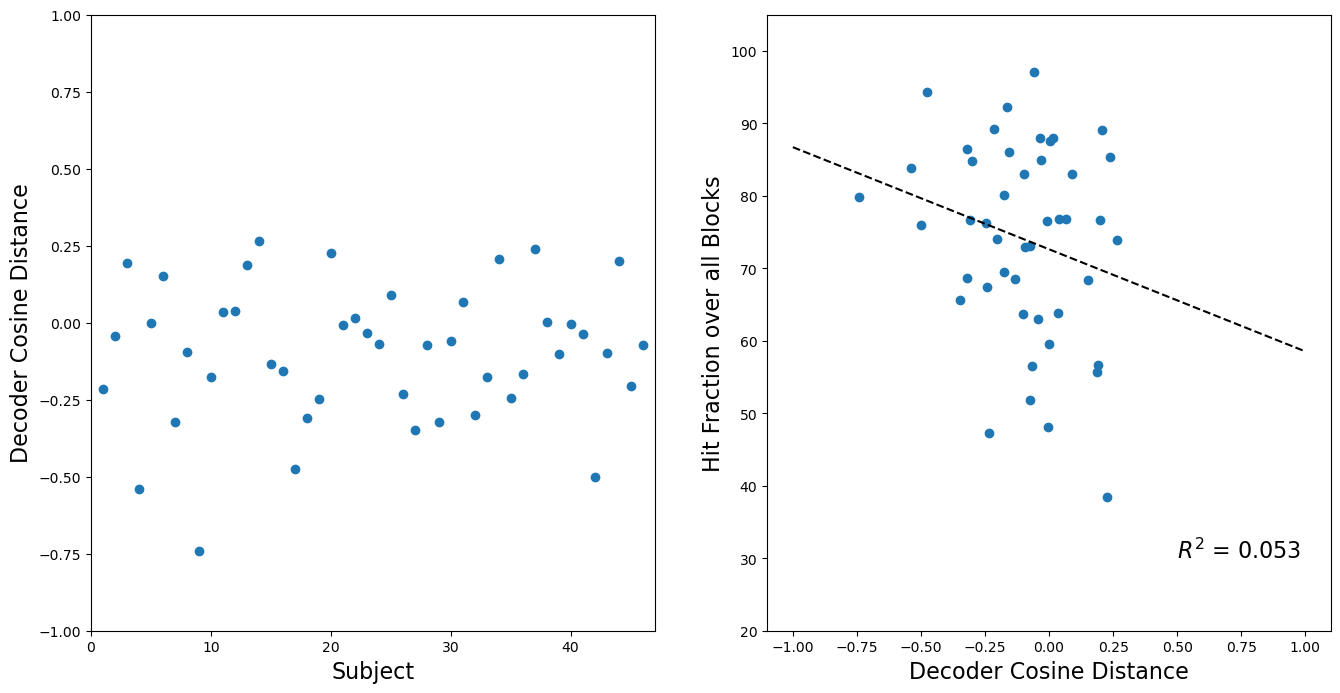

In [94]:
decoder_fig, (cos_ax, ax) = plt.subplots(1,2,figsize=(16,8))

# [-1,1] 1 is parallel, -1 is antiparallel, 0 is orthogonal
cos_ax.plot(range(1,len(cosines)+1), cosines,"o")
cos_ax.set_ylim([-1,1])
cos_ax.set_xlim([0,len(cosines)+1])
cos_ax.set_ylabel("Decoder Cosine Distance", fontsize=16)
cos_ax.set_xlabel("Subject", fontsize=16)

ax.plot(cosines, total_fractions ,"o")
from scipy.stats import linregress
result = linregress(cosines, total_fractions)
x = np.linspace(-1,1,100)
ax.plot(x, result.intercept + result.slope*x,"k--")
print(result.rvalue**2)
ax.set_ylim([20,105])
ax.set_xlim([-1.1,1.1])
ax.set_ylabel("Hit Fraction over all Blocks", fontsize=16)
ax.set_xlabel("Decoder Cosine Distance", fontsize=16)
ax.annotate(f"$R^2$ = {np.round(result.rvalue**2, 3)}", (0.5,30), fontsize=16)

In [95]:
decoder_fig.savefig("/Users/spencer/motor-control/thesis/images/data_analysis2023/decoder_correlation.pdf", dpi=300, format="pdf")